Let's import useful libraries.

In [1]:
from matplotlib import pyplot as plt
from matplotlib import style

from mlxtend.plotting import plot_decision_regions

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm

import itertools
import numpy as np
import random

In [2]:
style.use(style='seaborn-whitegrid')

In [3]:
X, y = make_classification(n_samples=10000,
                           n_features=2,
                           n_informative=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

In [4]:
print(len(X_train))
print(len(X_test))

7500
2500


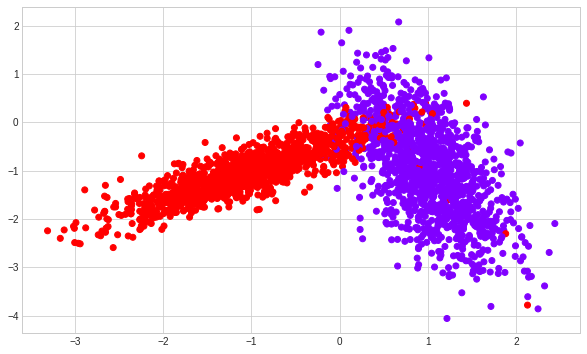

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='rainbow')
plt.show()

__Implementing Custom RandomSearchCV__

In [6]:
def get_fold_indices(folds) -> list:
    """
    This function provides the indices for k-fold validation.
    """
    combs = list(itertools.combinations(iterable=range(folds), r=folds-1))
    all_combs = [(list(tr_i), [te_i])
                 for tr_i, te_i in zip(combs, list(range(folds))[::-1])]
    return all_combs

In [7]:
print(get_fold_indices(folds=3))

[([0, 1], [2]), ([0, 2], [1]), ([1, 2], [0])]


In [8]:
def supply_fold_data(folds, X_train, y_train) -> tuple:
    """
    This function is used to split and supply the data based on folds.
    """
    X_train_splits = np.array_split(ary=X_train, indices_or_sections=folds)
    X_train_splits = np.array(X_train_splits, dtype=object)
    
    y_train_splits = np.array_split(ary=y_train, indices_or_sections=folds)
    y_train_splits = np.array(y_train_splits, dtype=object)
    y_train_splits = y_train_splits.astype('int')
    return X_train_splits, y_train_splits

In [9]:
def RandomSearchCV(X_train, y_train, classifier, param_range, folds) -> tuple:
    """
    This function implements RandomSearchCV.
    """
    train_scores = list()
    test_scores = list()
    
    params = np.array(random.sample(
        population=range(param_range[0], param_range[1]), k=10))
    params = np.sort(params)
    fold_indices = get_fold_indices(folds=folds)
    X_train_splits, y_train_splits = supply_fold_data(folds=folds,
                                                      X_train=X_train,
                                                      y_train=y_train)
    for k in tqdm(params):
        train_fold_scores = list()
        test_fold_scores = list()
        
        for tr_fi, te_fi in fold_indices:
            X_train_fold = np.vstack((X_train_splits[tr_fi]))
            y_train_fold = np.hstack((y_train_splits[tr_fi]))
            
            X_test_fold = np.vstack((X_train_splits[te_fi]))
            y_test_fold = np.hstack((y_train_splits[te_fi]))
            
            classifier.n_neighbors = k
            classifier.fit(X_train_fold, y_train_fold)
            
            train_f_pred = classifier.predict(X_train_fold)
            train_f_acc = accuracy_score(y_true=y_train_fold,
                                         y_pred=train_f_pred)
            train_fold_scores.append(train_f_acc)
            
            test_f_pred = classifier.predict(X_test_fold)
            test_f_acc = accuracy_score(y_true=y_test_fold,
                                        y_pred=test_f_pred)
            test_fold_scores.append(test_f_acc)
            
        train_scores.append(np.mean(np.array(train_f_acc)))
        test_scores.append(np.mean(np.array(test_f_acc)))
    return params, np.array(train_scores), np.array(test_scores)

In [10]:
classifier = KNeighborsClassifier()
param_range = (1, 50)
folds = 5

In [11]:
params, train_scores, cv_scores = RandomSearchCV(X_train=X_train,
                                                 y_train=y_train,
                                                 classifier=classifier,
                                                 param_range=param_range,
                                                 folds=folds)

100%|███████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


In [12]:
def optimal_hyper_parameter(params, train_scores, cv_scores) -> int:
    """
    This function finds the best hyper-parameter k.
    """
    dists = np.absolute(train_scores - cv_scores)
    min_dis = np.argmin(dists)
    return params[min_dis]

In [13]:
best_k = optimal_hyper_parameter(params=params,
                                 train_scores=train_scores,
                                 cv_scores=cv_scores)
print("Best k is {}.".format(best_k))

Best k is 40.


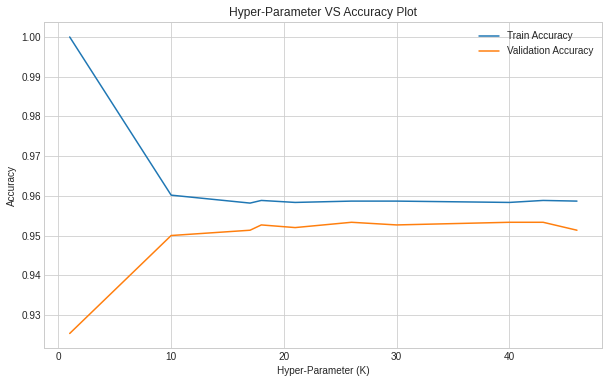

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(params, train_scores, label='Train Accuracy')
plt.plot(params, cv_scores, label='Validation Accuracy')
plt.title(label='Hyper-Parameter VS Accuracy Plot')
plt.xlabel(xlabel='Hyper-Parameter (K)')
plt.ylabel(ylabel='Accuracy')
plt.legend()
plt.show()

In [15]:
def display_decision_surface(X, y) -> None:
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X, y)
    plt.figure(figsize=(10, 6))
    plot_decision_regions(X=X, y=y, clf=knn, legend=2)
    plt.show()
    return None

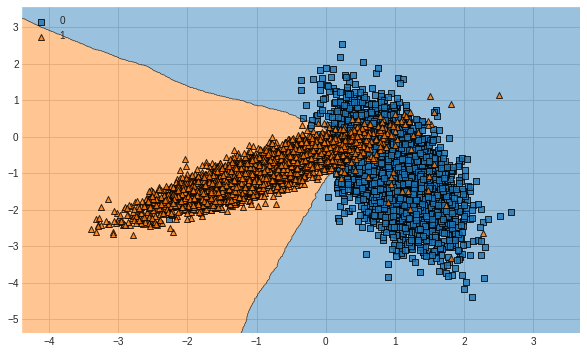

In [16]:
display_decision_surface(X=X_train, y=y_train)

End of the file.